**This Jupyter Notebook comes with a master thesis. It focuses on performing intrinsic analysis on OpenStreetMap (OSM) data. This means that the quality evaluation is based solely on the data and its associated metadata. The main goal of these initial evaluations is to get an overview of the data, make heuristic quality statements, compare different geographic areas and determine the suitability for specific purposes. This approach is in line with previous studies on quality assessment of Volunteered Geographic Information (VGI) data, which are referenced in each section. The notebook classifies OSM line features into three infrastructure classes. In addition, users can define and evaluate any other class they wish. For example, one-way streets where bicycles are allowed to ride against the one-way direction could be scored.**

**The notebook is divided into four main sections. In the first, the study area is selected, the data is prepared and the data is downloaded using the Overpass API. The second section (E1) gives an overview of the data and calculates some network based metrics. The third section (E2) looks at the history of the OSM features and the final section (E3) looks at how often the features have been edited.**

# P1: Data Preparation

## Import libraries

In [1]:
try:
    import google.colab
    import os

    # Clone the repository
    if not os.path.exists("/content/osm-bike-analysis"):
        !git clone https://github.com/marcelharing/osm-bike-analysis.git
        pass

    # Change the working directory
    %cd osm-bike-analysis

    # Install dependencies
    !pip --quiet install -r requirements.txt

    # Google Colab saves files in an folder named content
    diskpath = os.getcwd()
    
except ImportError:
    diskpath = '.' # relative file path

In [2]:
#### LIBRARIES ####
import osmnx
import json
import ipywidgets as widgets

import os
import codecs
import osm2geojson
import geopandas as gpd
import contextily as cx
import momepy
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar # for scalebar
from matplotlib.colors import LinearSegmentedColormap # for custom cmaps
 

from datetime import datetime
from dateutil.relativedelta import relativedelta
import requests
import plotly.graph_objects as go

import seaborn as sns
import pandas as pd

from functions import *

## Choose a city, town or region as study area

⏩ You can choose any **administrative boundary** (as relation) in OSM. Search for it like in [Nominatim](https://nominatim.openstreetmap.org/ui/search.html), for example: *Innsbruck, Austria*

In [3]:
!pip install matplotlib_scalebar

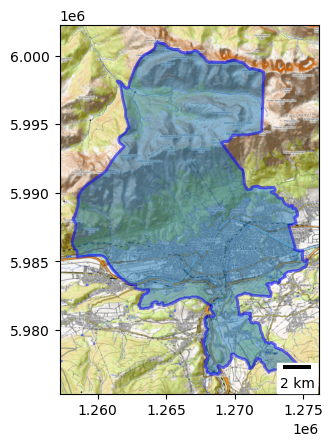

In [4]:
#### CHOOSE THE CITY, TOWN OR REGION YOU WANT TO ANALYZE ####
nominatim_area = input("Please enter the city, town or region you want to analyze: ")

gdf_area = osmnx.geocode_to_gdf(nominatim_area)

# Plot the area with a larger figure size
f, ax = plt.subplots()  # Adjust the figsize as needed
gdf_area.to_crs(epsg=3857).plot(ax=ax, alpha=0.5, edgecolor="b", linewidth=2)
cx.add_basemap(
    ax,
    source="https://tile.opentopomap.org/{z}/{x}/{y}.png",
)

# Add scale bar
scalebar = ScaleBar(1, location='lower right')  # 1 pixel = 1 meter
ax.add_artist(scalebar)

# Get the area as a GEOJSON file
gjson_area = gdf_area.to_json()

# areaID is always osm_id + 3600000000, has to be a relation, gdf_area.osm_id comes from osmnx nominatim query above
areaId = gdf_area.osm_id[0] + 3600000000

plt.show()

## Overpass Queries

Overpass is a web API that allows users to get and **filter specific OSM features**. It has its own [query language](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL).

All queries are already defined and nothing needs to be done anymore. But if you want to analyse **your own set of OSM attributes** (for example, all one-way streets where bicycles can also travel against the one-way traffic flow), you can define and analyse your own infrastructure class.  You can use the Overpass [Turbo Wizard](https://overpass-turbo.eu/) to do this. However, the query output should be in XML format `[out:xml] ` and return also metadata `out meta;` so it should look like this:
```[out:xml][timeout:200];
area(id:{areaId})->.searchArea;
(
  FEATURES SETS HERE
);
(._;>;);
out meta;
```
Note that if you select attributes that are already in the other queries, there may be duplicates when summed up to total bicycle infrastructure.


In [5]:
#### OVERPASS QUERYS ####

### CYCLE LANES ###
query_cycletracks = f"""
/*
“(highway=cycleway   OR (highway=path OR highway= footway) AND (bicycle=designated OR bicycle=yes OR bicycle=permissive)  OR (cycleway=track OR cycleway=opposite_track)  OR (cycleway:right=track OR cycleway:right=opposite_track)  OR (cycleway:left=track OR cycleway:left=opposite_track)  OR (cycleway:both=track OR cycleway:both=opposite_track) ) in Innsbruck”
*/
[out:xml][timeout:200];
area(id:{areaId})->.searchArea;
(
  way["highway"="cycleway"](area.searchArea);
  way["highway"="path"]["bicycle"="designated"](area.searchArea);
  way["highway"="path"]["bicycle"="yes"](area.searchArea);
  way["highway"="path"]["bicycle"="permissive"](area.searchArea);
  way["highway"="footway"]["bicycle"="designated"](area.searchArea);
  way["highway"="footway"]["bicycle"="yes"](area.searchArea);
  way["highway"="footway"]["bicycle"="permissive"](area.searchArea);
  way["cycleway"="track"](area.searchArea);
  way["cycleway"="opposite_track"](area.searchArea);
  way["cycleway:right"="track"](area.searchArea);
  way["cycleway:right"="opposite_track"](area.searchArea);
  way["cycleway:left"="track"](area.searchArea);
  way["cycleway:left"="opposite_track"](area.searchArea);
  way["cycleway:both"="track"](area.searchArea);
  way["cycleway:both"="opposite_track"](area.searchArea);
);
(._;>;);
out meta;
"""
### CYCLE LANES ###
query_cyclelanes= f"""
/*
“(cycleway=lane OR cycleway=opposite_lane) OR (cycleway:right=lane OR cycleway:right=opposite_lane) OR (cycleway:left=lane OR cycleway:left=opposite_lane) OR (cycleway:both=lane OR cycleway:both=opposite_lane) in Innsbruck”
*/
[out:xml][timeout:200];
area(id:{areaId})->.searchArea;
(
  way["cycleway"="lane"](area.searchArea);
  way["cycleway"="opposite_lane"](area.searchArea);
  way["cycleway:right"="lane"](area.searchArea);
  way["cycleway:right"="opposite_lane"](area.searchArea);
  way["cycleway:left"="lane"](area.searchArea);
  way["cycleway:left"="opposite_lane"](area.searchArea);
  way["cycleway:both"="lane"](area.searchArea);
  way["cycleway:both"="opposite_lane"](area.searchArea);
);
(._;>;);
out meta;
"""

### CALM TRAFFIC WAYS ####
query_calmtrafficways= f"""
/*
The original search was:
“(  (highway=track OR highway=service OR highway=unclassified OR highway=residential) AND bicycle!=* AND (motor_vehicle=private OR motor_vehicle=no OR motor_vehicle=customers OR motor_vehicle=agricultural OR motor_vehicle=forestry OR motor_vehicle=destination OR motor_vehicle=delivery) ) OR  (  (highway=track OR highway=service OR highway=unclassified OR highway=residential) AND ( (motor_vehicle=private OR motor_vehicle=no OR motor_vehicle=customers OR motor_vehicle=agricultural OR motor_vehicle=forestry OR motor_vehicle=destination OR motor_vehicle=delivery) OR (access=private OR access=no OR access=customers OR access=agricultural OR access=forestry OR access=destination OR access=delivery) OR (vehicle=private OR vehicle=no OR vehicle=customers OR vehicle=agricultural OR vehicle=forestry OR vehicle=destination OR vehicle=delivery) ) AND (bicycle=designated OR bicycle=yes OR bicycle=permissive) ) OR ( highway=track  AND (bicycle=designated OR bicycle=yes OR bicycle=permissive) AND (motor_vehicle!=* AND access!=* AND vehicle!=*) ) OR ( highway=living_street ) OR ( bicycle_road=yes ) OR ( highway=pedestrian  AND (bicycle=designated OR bicycle=yes OR bicycle=permissive) )”
*/
[out:xml][timeout:240];
area(id:{areaId})->.searchArea;
(
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="private"](area.searchArea);
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="no"](area.searchArea);
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="customers"](area.searchArea);
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="agricultural"](area.searchArea);
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="forestry"](area.searchArea);
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="destination"](area.searchArea);
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="delivery"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="private"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="no"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="customers"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="agricultural"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="forestry"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="destination"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="delivery"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="private"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="no"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="customers"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="agricultural"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="forestry"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="destination"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="delivery"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="private"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="no"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="customers"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="agricultural"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="forestry"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="destination"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="delivery"](area.searchArea);
way["highway"="track"]["motor_vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["motor_vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["motor_vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["motor_vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["motor_vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["motor_vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["motor_vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["bicycle"="designated"]["motor_vehicle"!~".*"]["access"!~".*"]["vehicle"!~".*"](area.searchArea);
way["highway"="track"]["bicycle"="yes"]["motor_vehicle"!~".*"]["access"!~".*"]["vehicle"!~".*"](area.searchArea);
way["highway"="track"]["bicycle"="permissive"]["motor_vehicle"!~".*"]["access"!~".*"]["vehicle"!~".*"](area.searchArea);
way["highway"="living_street"]["area"!="yes"](area.searchArea);
way["bicycle_road"="yes"](area.searchArea);
way["highway"="pedestrian"]["bicycle"="designated"]["area"!="yes"](area.searchArea);
way["highway"="pedestrian"]["bicycle"="yes"]["area"!="yes"](area.searchArea);
way["highway"="pedestrian"]["bicycle"="permissive"]["area"!="yes"](area.searchArea);
);
(._;>;);
out meta;
"""

⏩ You can define your own infrastructure class if you wish, otherwise just run this cell and leave everything as it is:

In [6]:
#### OWN QUERY ####
if os.path.exists(f"{diskpath}/osm_data/export_own_osm2geojson.osm"):
    print("Delete existing file with own infrastructure data")
    os.remove(f"{diskpath}/osm_data/export_own_osm2geojson.osm")

# Put your own query here
query_own = ""

The data is retrieved from OSM using the Overpass API and the appropriate queries. This data is used to create a graph, nodes and edges for each bicycle infrastructure.

The graph is used for topological evaluations, in this notebook these are the betweenness centrality and orientation of the bicycle infrastructure.
Edges and nodes of the bicycle infrastructure network are derived from the graph; the former is used to visualise the network in the maps and plots.
Finally, a GeoDataFrame is generated directly from the OSM data. This contains additional metadata. The version of the OSM features (Linus Law) is analysed with this dataset.

In [7]:
#### CALL TO OVERPASS API ####
"""
The dictionary for each 'infr_class' contains the following elements:

- 'query': The query statement to retrieve data.
- 'name': The name of the infrastructure class.
- 'color': A unique color for visual representation.
- 'graph': routable directed and simplified OSMNX graph. 
  This graph is routable and represents the infrastructure in both directions (i.e. if edges are bidirectional, they exist twice).
  Like the other graphs it is projected and clipped to the study area at the next edge outside the study area.
- 'gdf_xml': A separate GeoDataFrame directly from the XML file. This GeoDataFrame includes 'version' and 'timestamp' columns,
  which are part of the Overpass API's meta output. Note that osmnx does not provide this metadata. However, the XML-derived
  GeoDataFrame is not routable and contains the original number of OSM features. The nodes which were used for osmnx will be excluded.
  To prevent errors, if there are no features a empty GDF is created.
"""
dict_cycle_tracks = {
    "query": query_cycletracks,
    "name": "cycle_tracks",
    "color": "#0a007b",
    "graph": "",
}
dict_cycle_lanes = {
    "query": query_cyclelanes,
    "name": "cycle_lanes",
    "color": "#006bff",
    "graph": "",
}
dict_calm_traffic_ways = {
    "query": query_calmtrafficways,
    "name": "calm_traffic_ways",
    "color": "#c63ddb",
    "graph": "",
}
dict_own = {"query": query_own, "name": "own", "color": "green", "graph": ""}
ls_classes = [dict_cycle_tracks, dict_cycle_lanes, dict_calm_traffic_ways, dict_own]

# Call Overpass API, built a OSMNX graph and a GeoDataFrame and update the dictionary with 'to_data_dict'
ls_classes = to_data_dict(
    ls_classes=ls_classes, area_name=nominatim_area, diskpath=diskpath, clip=False
)

No own infrastructur class choosen!


In [8]:
#### TOTAL INFRASTRUCTURE ####
"""
The dictionary for the total infrastructure (combined classes) contains the following elements:

- 'name': The name of the infrastructure class.
- 'color': A unique color for visual representation.
- 'graph': routable directed and simplified OSMNX graph. 
  This graph is routable and represents the infrastructure in both directions (i.e. if edges are bidirectional, they exist twice).
  Like the other graphs it is projected and clipped to the study area at the next edge outside the study area.
- 'gdf_xml': A separate GeoDataFrame directly from the XML file. This GeoDataFrame includes 'version' and 'timestamp' columns,
  which are part of the Overpass API's meta output. Note that osmnx does not provide this metadata. However, the XML-derived
  GeoDataFrame is not routable and contains the original number of OSM features.
"""

# Create a list of non-empty MultiDiGraphs created in the section above
graphs = [
    dict_cycle_tracks["graph"],
    dict_cycle_lanes["graph"],
    dict_calm_traffic_ways["graph"],
    dict_own["graph"],
]
graphs_valid = [x for x in graphs if x]  # only non-empty graphs allowed

if graphs_valid:
    # Combine the Graphs together into one if Gs_valid is not empty
    combined_Gs = nx.compose_all(graphs_valid)
    combined_Gs = osmnx.simplification.simplify_graph(combined_Gs)
else:
    raise ValueError("NO INFRASTRUCTURE IN YOUR STUDY AREA. STOPPING SCRIPT.")


# New column with infrastructure class to distinguish infr_classes in total GeoDataFrame
dict_cycle_tracks["gdf_xml"]["infr_class"] = "Cycle Tracks"
dict_cycle_lanes["gdf_xml"]["infr_class"] = "Cycle Lanes"
dict_calm_traffic_ways["gdf_xml"]["infr_class"] = "Calm Traffic Ways"
dict_own["gdf_xml"]["infr_class"] = "Own Infrastructure"

# Combine all classes in one total GeoDataFrame
combined_GDFs = gpd.GeoDataFrame(
    pd.concat(
        [
            dict_cycle_tracks["gdf_xml"],
            dict_cycle_lanes["gdf_xml"],
            dict_calm_traffic_ways["gdf_xml"],
            dict_own["gdf_xml"],
        ],
        ignore_index=True,
    ),
    crs=[
        dict_cycle_tracks["gdf_xml"],
        dict_cycle_lanes["gdf_xml"],
        dict_calm_traffic_ways["gdf_xml"],
        dict_own["gdf_xml"],
    ][0].crs,
)

dict_total = {"color": "#323232", "graph": combined_Gs, "gdf_xml": combined_GDFs}


C:\TEMP\TEMP\ipykernel_14344\442301602.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat(


In some rare cases there can be duplicates. This is the case when a feature is classified in more than one infrastructure class (for example because a street is a calm traffic way and has in addition cycle lanes).

In [9]:
# Drop duplicates in the GeoDataFrames
if dict_total["gdf_xml"].duplicated("geometry").any():
    print("Duplicates in GeodataFrame dropped.")
dict_total["gdf_xml"].drop_duplicates(subset="geometry", keep="first", inplace=True)

Duplicates in GeodataFrame dropped.


# E1: First Overview of Study Area and Bicycle Infrastructure

Get a first overview of the bicycle infrastructure in your study area with some basic maps and charts.

## Overview Maps and Orientation of bicycle infrastructure

The following maps and charts provide a spatial **overview of the characteristics of each infrastructure** in your study area.

In addition, the **orientation** of the infrastructure is calculated. This shows in which directions the cycling infrastructure as a whole is oriented and gives a sense of where the main infrastructure is oriented. For further background information see
* Boeing, G. (2019). Urban Spatial Order: Road network orientation, configuration and entropy. Applied Network Science, 4 (1), 67. https://doi.org/10.1007/s41109-019-0189-1

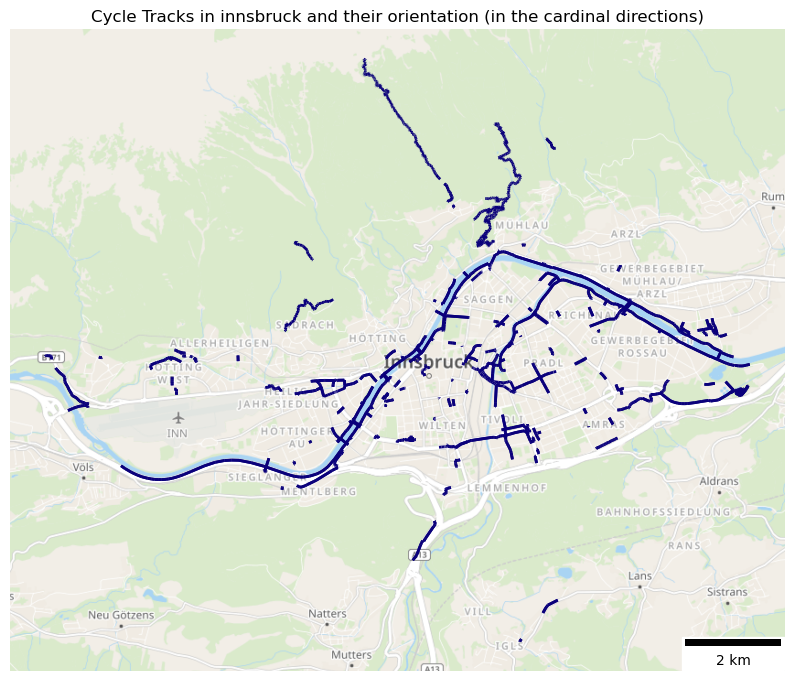

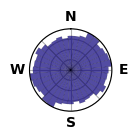

In [10]:
plot_infr(dict_cycle_tracks, "Cycle Tracks", nominatim_area)

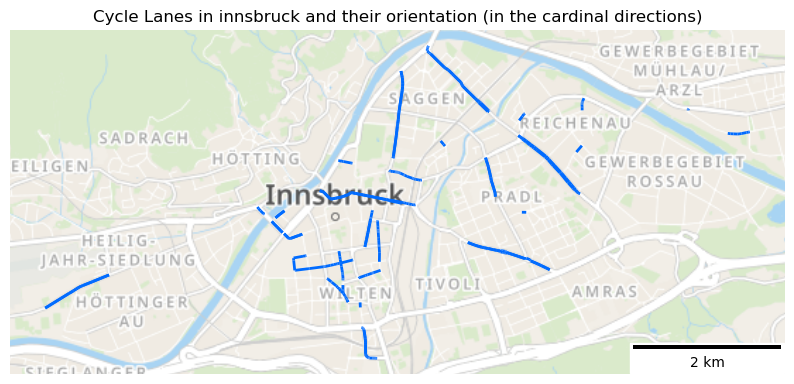

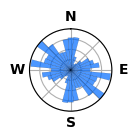

In [11]:
plot_infr(dict_cycle_lanes, "Cycle Lanes", nominatim_area)

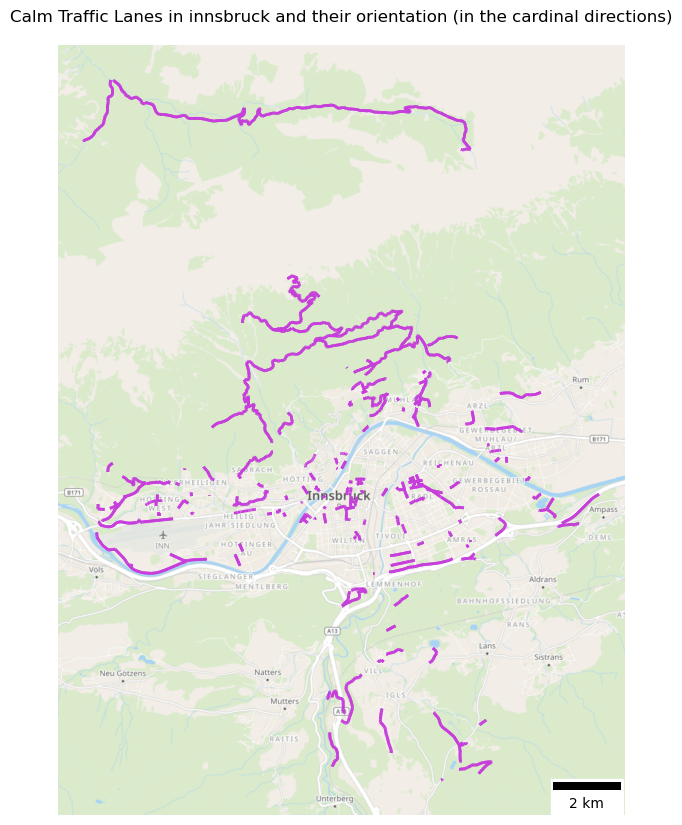

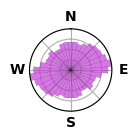

In [12]:
plot_infr(dict_calm_traffic_ways, "Calm Traffic Lanes", nominatim_area)

In [13]:
if dict_own["query"]:
    plot_infr(dict_own, "Own Infrastructure Class", nominatim_area)

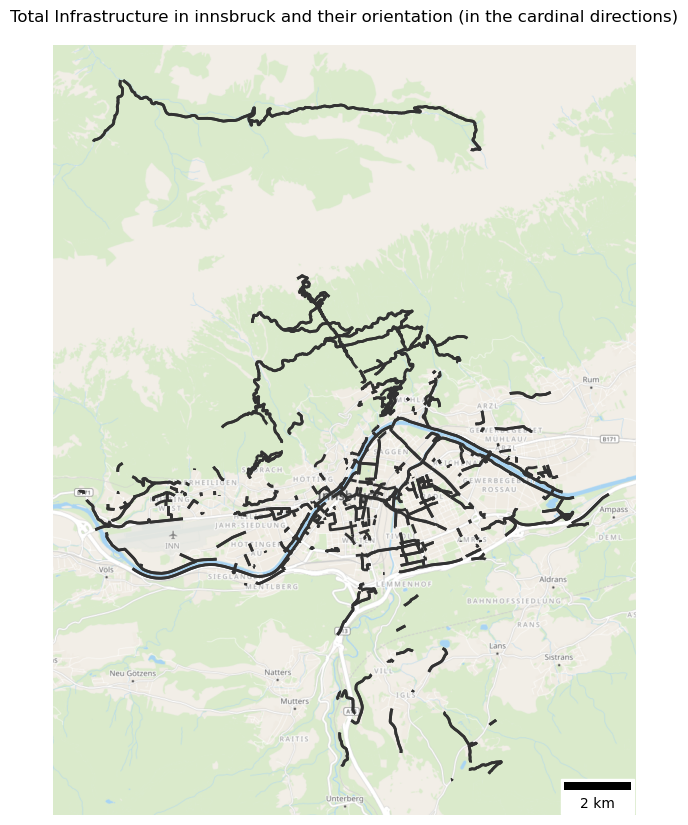

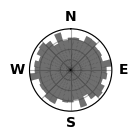

In [14]:
plot_infr(dict_total, "Total Infrastructure", nominatim_area)

## Betweenness Centrality

Betweenness centrality can give a sense of **how important each node or edge is in a network**. It is a graph theory metric that measures the importance of a node or edge by counting how many shortest paths pass through every node or edge, indicating its role in connecting different parts of the network.

In the context of cycle networks, it helps to get an overview of important edges where many others converge. However, due to the often disconnected and fragmented nature of cycle networks, the validity of betweenness centrality may be limited.

For more theoretical background information see:
* Porta, S., Crucitti, P., & Latora, V. (2006). The Network Analysis of Urban Streets: A Primal Approach. Environment and Planning B: Planning and Design, 33(5), 705-725. https://doi.org/10.1068/b32045
* [Betweenness centrality on Wikipedia](https://en.wikipedia.org/wiki/Betweenness_centrality)
* [Betweenness centrality on the documentation of the python library](https://docs.momepy.org/en/stable/generated/momepy.betweenness_centrality.html) and the corresponding  paper: <br> Fleischmann, M. (2019) ‘momepy: Urban Morphology Measuring Toolkit’, Journal of Open Source Software, 4(43), p. 1807. https://doi.org/10.21105/joss.01807

For an example study using betweenness centrality with bicycle networks see:
* Beck, B., Pettit, C., Winters, M., Nelson, T., Vu, H. L., Nice, K.,Saberi, M. (2024). Association between network characteristics and bicycle ridership across a large metropolitan region. International Journal of Sustainable Transportation, 18(4), 344–355. https://doi.org/10.1080/15568318.2024.2308266


In [15]:
#### BETWEENNESS CENTRALITY PREPARATION ####

# Project to appropriate UTM CRS
combined_graphs = osmnx.projection.project_graph(dict_total["graph"])

# Convert the undirected version of the combined graph to a GeoDataFrame of edges.
graphs_edges = osmnx.graph_to_gdfs(
    osmnx.convert.to_undirected(combined_graphs),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
)

# Convert the GeoDataFrame of edges to a NetworkX graph using the 'primal' approach.
primal = momepy.gdf_to_nx(graphs_edges, approach="primal")
# Compute the betweenness centrality for each edge in the graph with attribute betweenness_metric_e (centrality values)
primal = momepy.betweenness_centrality(
    primal, name="betweenness_metric_e", mode="edges", weight="mm_len"
)

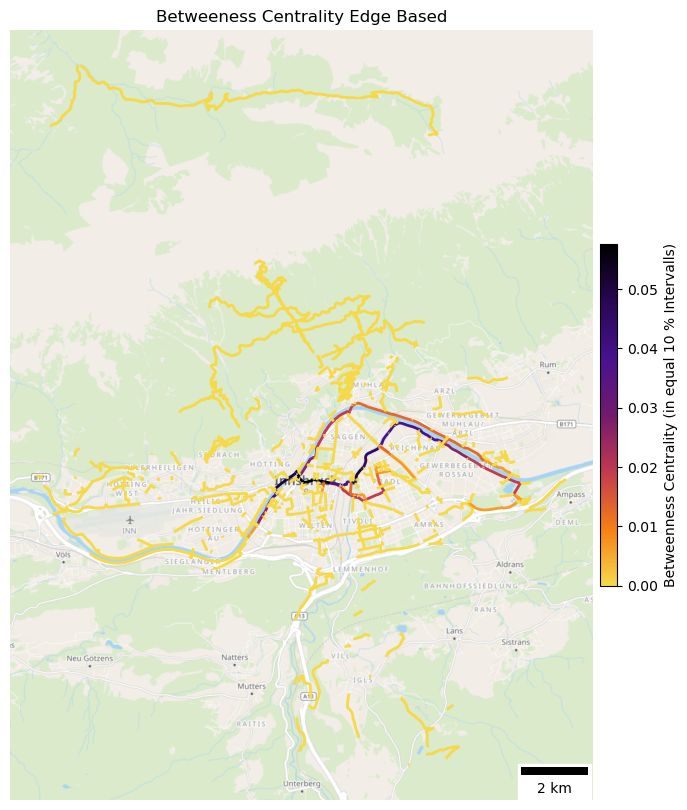

In [112]:

#### BETWEENESS CENTRALITY PLOT ####
# Back to GDF
primal_gdf = momepy.nx_to_gdf(primal, points=False)

# Convert the GeoDataFrame to Web Mercator projection
primal_gdf = primal_gdf.to_crs(epsg=3857)

# Define custom colormap
colors = ["#f5d949", "#F67E14", "#C13A50", "#721A6E",  "#48128e", "#280754", "#000000"]
custom_cmap = LinearSegmentedColormap.from_list("custom_inferno", colors)

# Plot with plt.plot
f, ax = plt.subplots(figsize=(10, 10))
cax = primal_gdf.plot(
    ax=ax,
    column="betweenness_metric_e",
    cmap=custom_cmap,
    scheme="equal_interval",
    classification_kwds={'k': 10},
    alpha=1,
    linewidth=2,
)
ax.set_axis_off()
ax.set_title("Betweeness Centrality Edge Based")

# Add contextily basemap
cx.add_basemap(
    ax,
    source="https://tile.thunderforest.com/atlas/{z}/{x}/{y}.png?apikey=3ad11fafa2564c1183c66f15224857b5",
)

# Add scale bar
scalebar = ScaleBar(1, location='lower right')  # 1 pixel = 1 meter
ax.add_artist(scalebar)

# Add color legend as color bar
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=primal_gdf["betweenness_metric_e"].min(), vmax=primal_gdf["betweenness_metric_e"].max()))
cbar = f.colorbar(sm, ax=ax, orientation='vertical', fraction=0.022, pad=0.01)
cbar.set_label("Betweenness Centrality (in equal 10 % Intervalls)")
plt.show()

# E2: History Analysis

This evaluation shows the **bicycle infrastructure in a time series** with [OSHDB](https://github.com/GIScience/oshdb) and OSHOME API. OSHDB stands for OpenStreetMap History Database and allows you to analyse the history of OpenStreetMap feature objects since 2008 for every possible region and time. OSHDB is written in Java, but is accessible with the [OSHOME Web API](https://docs.ohsome.org/ohsome-api/v1/).

<center>
<img src='https://i.imgur.com/cJ1GLrv.png' alt='drawing' width='400'/><br>
<small><i>Scheme of OSHDB from Auer et. al (2018)</i></small>
</center>

Depending on the growth rates, **you can estimate how complete the cycling infrastructure is** in your study area. This qualitative indicator helps to get a first impression. It is particularly useful when comparing with other areas, different infrastructure classes and their growth rates. For more information on the relationship between time and OSM completeness, see
* Barron, C., Neis, P. and Zipf, A. (2014). A Comprehensive Framework for Intrinsic OpenStreetMap Quality Analysis. Transactions in GIS, 18: 877-895. https://doi.org/10.1111/tgis.12073
* Neis, P., Zielstra, D., and Zipf, A. (2013). "Comparison of Volunteered Geographic Information Data Contributions and Community Development for Selected World Regions" Future Internet 5, no. 2: 282-300. https://doi.org/10.3390/fi5020282

For more information on the OHSOME platform see:
* Auer, M., Eckle, M., Fendrich, S., Kowatsch, F., Loos, L., Marx, S., Raifer, M., Schott, M., Troilo, R., Zipf, A. (2018). Ohsome – eine Plattform zur Analyse raumzeitlicher Entwicklungen von OpenStreetMap-Daten für intrinsische Qualitätsbewertungen. AGIT ‒ Journal für Angewandte Geoinformatik, 4-2018: 162-167. https://doi.org/10.14627/537647020
* Raifer, M., Troilo, R., Kowatsch, F. et al. OSHDB: a framework for spatio-temporal analysis of OpenStreetMap history data. Open geospatial data, softw. stand. 4, 3 (2019). https://doi.org/10.1186/s40965-019-0061-3

## Predefined queries for all time analysis

Queries are now passed in [Overpass Turbo Wizard language](https://wiki.openstreetmap.org/wiki/Overpass_turbo/Wizard). Therefore new queries have to be initialised for each class. Everything is already defined, but you can again define and analyse your own query with certain OSM attributes if you want.

In [17]:
#### OVERPASS TURBO WIZARD QUERIES ####
# OSHOME needs explexitely Overpass Turbo wizard statements
opwizquery_cycle_tracks = 'highway=cycleway or (highway=path or highway= footway) and (bicycle=designated or bicycle=yes or bicycle=permissive) or (cycleway=track or cycleway=opposite_track) or (cycleway:right=track or cycleway:right=opposite_track) or (cycleway:left=track or cycleway:left=opposite_track) or (cycleway:both=track or cycleway:both=opposite_track)'
opwizquery_cycle_lanes = '(cycleway=lane or cycleway=opposite_lane) or (cycleway:right=lane or cycleway:right=opposite_lane) or (cycleway:left=lane or cycleway:left=opposite_lane) or (cycleway:both=lane or cycleway:both=opposite_lane)'
opwizquery_calm_traffic_ways = '((highway=track or highway=service or highway=unclassified or highway=residential) and bicycle!=* and (motor_vehicle=private or motor_vehicle=no or motor_vehicle=customers or motor_vehicle=agricultural or motor_vehicle=forestry or motor_vehicle=destination or motor_vehicle=delivery)) or ((highway=track or highway=service or highway=unclassified or highway=residential) and ( (motor_vehicle=private or motor_vehicle=no or motor_vehicle=customers or motor_vehicle=agricultural or motor_vehicle=forestry or motor_vehicle=destination or motor_vehicle=delivery) or (access=private or access=no or access=customers or access=agricultural or access=forestry or access=destination or access=delivery) or (vehicle=private or vehicle=no or vehicle=customers or vehicle=agricultural or vehicle=forestry or vehicle=destination or vehicle=delivery) ) and (bicycle=designated or bicycle=yes or bicycle=permissive)) or (highway=track and (bicycle=designated or bicycle=yes or bicycle=permissive) and (motor_vehicle!=* and access!=* and vehicle!=*) ) or (highway=living_street) or (bicycle_road=yes) or (highway=pedestrian and (bicycle=designated or bicycle=yes or bicycle=permissive))'
opwizquery_main_roads = 'highway=unclassified or highway=residential or highway=tertiary or highway=secondary'
opwizquery_own = False

dict_opwizqueries = {
    "cycle_tracks": opwizquery_cycle_tracks,
    "cycle_lanes": opwizquery_cycle_lanes,
    "calm_traffic_ways": opwizquery_calm_traffic_ways,
    "main_roads": opwizquery_main_roads,
    "own": opwizquery_own,
}

## Final Charts over Time

For each graph, the characteristics are classified by infrastructure class. The time series runs from 2008 to the present, with values for every 6th month. If you wish, you can also plot the main road characteristics as an additional infrastructure class to get a better comparison for the cycling infrastructure. This helps to assess the completeness of cycling infrastructure, as the main road network in OSM can be considered as complete in Europe.

<big>⌛</big>Calling the OSHOME API can take 1-2  minutes for each plot at very large areas!<big>⌛</big>

⏩ Plot also main traffic road network?

In [18]:
#### INCLUDE MAIN ROADS ? ####
w = widgets.RadioButtons(
    options=[False, True], description="Main roads:", disabled=False
)
display(w)

RadioButtons(description='Main roads:', options=(False, True), value=False)

In [19]:
print("Include main roads: ", w.value)

Include main roads:  False


### Total Amount of Features
Quarterly time series from every first day of every 3rd month to the present, for each class of infrastructure.

In [20]:
import importlib
import functions

# Reload the entire module
importlib.reload(functions)

# Re-import the specific function
from functions import load_plot

In [21]:
load_plot(
    gjson_area,
    "https://api.ohsome.org/v1/elements/count",
    querydict=dict_opwizqueries,
    ylabel="Amount of Features",
    roads=w.value,
)

### Length of Features
Quarterly time series from every first day of every 3rd month to the present, for each class of infrastructure.

In [22]:
load_plot(
    gjson_area,
    "https://api.ohsome.org/v1/elements/length",
    querydict=dict_opwizqueries,
    ylabel="Length of Features (in m)",
    roads=w.value,
)

### Length of Feature Density
Length of elements (in meter) divided by the total area (in square-kilometers), quarterly time series from every first day of every 3rd month to the present, for each class of infrastructure.

In [23]:
load_plot(
    gjson_area,
    "https://api.ohsome.org/v1/elements/length/density",
    querydict=dict_opwizqueries,
    ylabel="Length of Feature Density (in m/km²)",
    roads=w.value,
)

### Contributions Count Density
Number of contributions (by OSM users) divided by total area (in square kilometres), quarterly time series in 3-month intervals up to the present, for each class of infrastructure.

In [24]:
load_plot(
    gjson_area,
    "https://api.ohsome.org/v1/contributions/count/density",
    querydict=dict_opwizqueries,
    ylabel="Contribution Count Density (per km²) <br> in 3 month interval",
    roads=w.value,
)

# E3: Linus Law: Version of OSM Features

Overpass can return the version of a feature. The version indicates **how many times a feature has been edited**. Features in OSM are marked as edited if the geometry or attributes have been edited. Linus Law points out that "given enough eyeballs, all errors are shallow". In this context, this means that if more people edit something, there is a **chance of higher correctness**.

The **distribution shows how many features have been edited and how often**. The 10% quantile shows that 10% of the features have at least the given version and 90% have a higher version. The distribution is finally shown in a histogram graphically.

For more background information to the relation of OSM version and correctness see:
* Keßler, C., de Groot, R.T.A. (2013). Trust as a Proxy Measure for the Quality
of Volunteered Geographic Information in the Case of OpenStreetMap. In: Vandenbroucke, D., Bucher, B., Crompvoets, J. (eds) Geographic Information Science at the Heart of Europe. Lecture Notes in Geoinformation and Cartography. Springer, Cham. https://doi.org/10.1007/978-3-319-00615-4_2
* Haklay, M. (2010). How Good is Volunteered Geographical Information? A Comparative Study of OpenStreetMap and Ordnance Survey Datasets. Environment and Planning B: Planning and Design 37 (4), 682–703. https://doi.org/10.1068/b35097.

In [25]:
#### STATISTICS / LOCATION PARAMETERS ####

# Combine all classes in one GDF
gdf_total = dict_total["gdf_xml"]

# Set up DF with median, 25% and 10% quantile for version of cycle tracks, cycle lanes, calm traffic ways and total
list_df = [
    dict_cycle_tracks["gdf_xml"],
    dict_cycle_lanes["gdf_xml"],
    dict_calm_traffic_ways["gdf_xml"],
    dict_own["gdf_xml"],
    gdf_total,
]  # list of all gdfs for function below


statistics = [
    calculate_dist_statistics(df, "version") for df in list_df
]  # returns median, 0.25q, 0.1q and puts in list

df_versions2 = pd.DataFrame(
    statistics,
    columns=["Median", "First Quartile (25%)", "10 % Quantile"],
    index=[
        "Cycle Tracks",
        "Cycle Lanes",
        "Calm Traffic Ways",
        "Own Infrastructure",
        "Total",
    ],
)
df_versions2

,Median,First Quartile (25%),10 % Quantile
Cycle Tracks,6.0,3.0,1.0
Cycle Lanes,14.0,9.0,5.0
Calm Traffic Ways,7.0,4.0,2.0
Own Infrastructure,NaN,NaN,NaN
Total,7.0,4.0,2.0


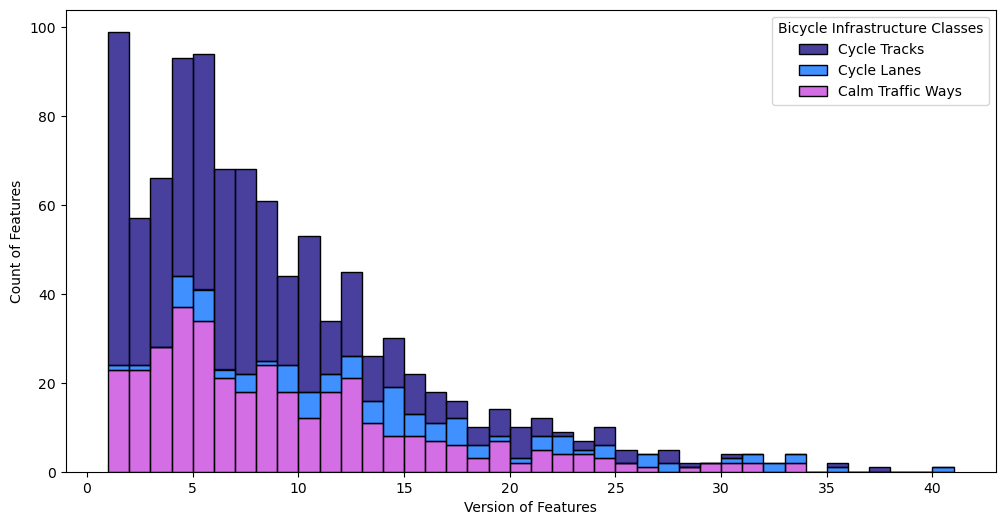

In [26]:
#### HISTOGRAM ####
colors = {
    "Cycle Tracks": dict_cycle_tracks["color"],
    "Cycle Lanes": dict_cycle_lanes["color"],
    "Calm Traffic Ways": dict_calm_traffic_ways["color"],
    "Own Infrastructure": dict_own["color"],
}

# Seaborn plot
amount_bins = gdf_total.version.unique().max() - gdf_total.version.unique().min()
plt.figure(figsize=(12, 6))
plt.xlabel("Version of Features")
plt.ylabel("Count of Features")
sns.histplot(
    gdf_total,
    x="version",
    multiple="stack",
    hue="infr_class",
    bins=amount_bins,
    palette=colors,
)

# Current axes /chart
ax = plt.gca()
# Get legend from the current axes and set own title
legend = ax.legend_.set_title("Bicycle Infrastructure Classes")